<font size="5">Build Your Own ANUGA Model (BYOAM) </font>

<font size="3">In this notebook, we will:

- set model configuration parameters

- download and preprocess elevation and landcover datasets
    
- Deteremine water body polygons

- Build the Digital Elevation Model </font>

<font size="3">This could take some time, depending on model domain size and complexity of the water mask</font>

<font size="3">Before you can run this notebook, you should have run 0_InitiateProcess notebook</font>


<font size=3> Give the name of your study area, must be the same in all noteboks </font>

In [1]:
AOI = 'gabon'

<font size="3">We'll start by importing packages</font>

In [2]:
import sys
import os
import pandas as pd
import shutil
from datetime import datetime
from string import Template
import fnmatch
import geopandas as gpd
import rasterio
from osgeo import gdal 
from pathlib import Path
import matplotlib.pyplot as plt
import numpy as np



<font size="3">And set the paths for necessary files</font>

In [3]:
path = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
path_code = path + '/processing/code/'
path_templates = path + '/processing/templates/'
path_examples =  '/Volumes/FortressL3/ANUGA/SWOT_Sim' + '/examples/' 
path_ancillary = path + '/ancillary/'
path_configs = path + '/processing/configs/'

sys.path.insert(1,path_code)
from BYOM_Utilities_V1 import (build_directory,
                               get_extent_parameters,
                               setup_AOI_files, 
                               make_polygons,
                               make_channel_networks,
                               make_model_foundation, 
                               set_boundary_conditions, 
                               make_watermask,
                               more_opening)
configfile = path_configs + '/Deltas_SetupParameters_MASTER_V2.csv' # #'Deltas_SetupParameters_MASTER_V2.csv'path_configs + 'need_opening.csv'#'
parameter_file = pd.read_csv(configfile)
AOIs = parameter_file['AOI']


/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:39: UserWarning: ShapelyDeprecationWarning
  warnings.warn('ShapelyDeprecationWarning')
/users/alchrist/documents/github/ANUGA/processing/code/raster_bridges.py:40: UserWarning: UserWarning
  warnings.warn('UserWarning')


<font size='5' color = 'red' > STEP #1: <br> Set the AOI again and make sure the working directory is set. If you ran 0_InitiateProcess notebook then the directory should already be made. </font>


In [4]:
Path((path_examples + AOI)).mkdir(parents=True, exist_ok=True)

skip = False
res = 30 #meters
print('\n')
print('Study area is ' + AOI)
print('Resolution of this setup is %sm' %(res))

working_path,folders = build_directory(path_examples, AOI)




Study area is gabon
Resolution of this setup is 30m



##############################################################################################
################################[Step 1][Build Directory]#####################################
##############################################################################################

##################### The working directory set as: 

/Volumes/FortressL3/ANUGA/SWOT_Sim/examples/gabon/
 
##################### Folders are:
##################### 0 User_Defined_Files --> User shapefile of model domain and water mask
##################### 1 tmp --> For temporary files
##################### 3 Meshes --> Where we will build model meshes
##################### 4 DEMs --> Where we will build digital elevation models
##################### 5 Boundaries --> Where we will store boundary files
##################### 6 Simulations --> Where we will run simulations
##################### 7 Setup_Files/Setup_SHP --> Shapefiles for setup 
########

<font size='5' color = 'red' > Here we set the necessary configuration parameters </font>


<font size="3">If you want to change any parameters see a list of options for each</font>

In [5]:
parameters = pd.DataFrame()
parameters['AOI'] = [AOI]
parameters['area_m2'] = '2927792509'
parameters['perimeter_m'] = '220499.16'
parameters['RiverOceanBoundary'] = '1260'
parameters['Discharge'] = '426'
parameters['ExtentFile'] = 'Ebro_input.shp'

#Method parameters:
parameters['LandcoverMethod'] = 'WorldCover'
parameters['LandElevMethod'] = 'GLO30'
parameters['OceanElevMethod'] = 'GEBCO'
parameters['LowerRiverElevMethod'] = 'plane'
parameters['UpperRiverElevMethod'] = 'wdpower'
parameters['WetlandElevMethod'] = 'constant_0'
parameters['LakeElevMethod'] = 'constant_1'
parameters['ManningLUT'] = 'default'
parameters['WetlandClass'] = '90'

#Coefficients for determining bathymetry:
parameters['BEDINTERCEPT_lower'] = '0.0000403'
parameters['BEDSLOPE_lower'] = '0.00000599'
parameters['BEDINTERCEPT_upper'] = '0.0000403'
parameters['BEDSLOPE_upper'] = '0.00000599'
parameters['WD_LINEARSLOPE_lower'] = '0.0123'
parameters['WD_LINEARINTERCEPT_lower'] = '0.9628'
parameters['WD_LINEARSLOPE_upper'] = '0.0123'
parameters['WD_LINEARINTERCEPT_upper'] = '0.9628'
parameters['WD_POWERA_lower'] = '0.0606'
parameters['WD_POWERB_lower'] = '0.7732'
parameters['WD_POWERA_upper'] = '0.0606'
parameters['WD_POWERB_upper'] = '0.7732'

#Max thresholds:
parameters['MaxOceanDepth'] = '-300'
parameters['MaxNearshoreDepth'] = '-300'
parameters['MaxRiverDepth'] = '-300'
parameters['MaxRiverWidth'] = '756'

parameters = parameter_file[parameter_file['AOI']==AOI.capitalize()].reset_index(drop=True)


<font size='5' color = 'red' > STEP #2: <br> Get extent parameters for the model </font>


In [6]:
ref_10m,parameters = get_extent_parameters(path_ancillary,AOI,folders,res,parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### AOI extent is set by: gabon_input.shp

[Step 2][Setup_AOI_Files][Determine EPSG code and UTM zone] .......

##################### ANUGA Models must be in UTM
##################### UTM Zone: 32n
##################### EPSG: 32232 

[Step 2][Setup_AOI_Files][Extending AOI by 1000m] .......


[Step 2][Setup_AOI_Files][Setting up AOI extent] .......

##################### AOI bounds are : 502740, -9880, 613100, 79190
##################### Approximate area of AOI extent is 9831.0 km^2

[Step 2][Setup_AOI_Files][Downloading GEBCO Dataset as reference for projection, resolution, etc] .......


[Step 2][Setup_AOI_Files][Saving configuration file] .......

##################### Saved as /Se

<font size='5' color = 'red' > The parameters were saved to a configuration file, we open that here </font>


In [7]:
parameters = pd.read_csv('%s/%s_Configuration.csv' %(folders[2],AOI))
print(parameters.iloc[0] )

Unnamed: 0                                0
AOI                                   Gabon
area_m2                        9080000000.0
perimeter_m                       385951.61
RiverOceanBoundary                  12200.0
Discharge                             300.0
ExtentFile                  Gabon_input.shp
LandcoverMethod                  WorldCover
LandElevMethod                        GLO30
OceanElevMethod                       GEBCO
LowerRiverElevMethod                  plane
UpperRiverElevMethod                wdpower
WetlandElevMethod                constant_0
LakeElevMethod                   constant_1
ManningLUT                          default
WetlandClass                           90.0
BEDINTERCEPT_lower                      NaN
BEDSLOPE_lower                          NaN
BEDINTERCEPT_upper                      NaN
BEDSLOPE_upper                          NaN
WD_LINEARSLOPE_lower                 0.0137
WD_LINEARINTERCEPT_lower             0.6794
WD_LINEARSLOPE_upper            

<font size='5' color = 'red' > STEP #2: <br> Download GEBCO, GLO30, World Cover, and Global Mangrove Maps for the area</font>

In [8]:
ref = setup_AOI_files(path,
                    AOI,
                    folders,
                    res,
                    parameters)





##############################################################################################
#################################[Step 2][Setup_AOI_Files]####################################
##############################################################################################

##################### Reference raster is gabon_GEBCO_30.tif
##################### This profile will be used for all future warping
##################### Resolution is 30m

[Step 2][Setup_AOI_Files][Compiling OCEAN elevation dataset] .......

##################### Ocean elevation set with:  GEBCO

[Step 2][Setup_AOI_Files][Compiling LAND elevation dataset] .......

##################### Land elevation set with: GLO30

[Step 2][Setup_AOI_Files][Compiling Landcover Classification Maps] .......

##################### Landcover types based on: WorldCover

[Step 2][Setup_AOI_Files][Loading Global Mangrove Watch ] .......


[Step 3A][Make_Watermask][Delineating wetland areas] ......


[Step 3A][Make_Watermas

<font size='5' color = 'red' > The EPSG coordinate reference system is in UTM </font>


In [9]:
EPSG = parameters['EPSG'][0]
ulx = parameters['ulx'][0]
uly = parameters['uly'][0]
lrx = parameters['lrx'][0]
lry = parameters['lry'][0]


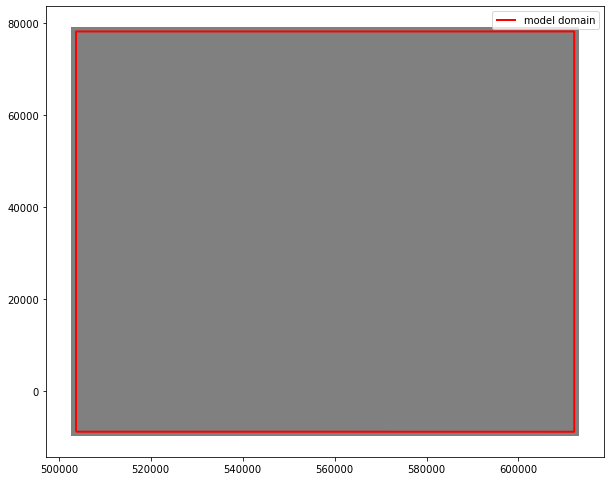

In [10]:
model_domain = gpd.read_file('%s%s_modeldomain.shp' %(folders[7],AOI))
AOI_extent = gpd.read_file('%s%s_extent_%s.shp' %(folders[7],AOI,EPSG))

clean_with_landcover = False
ref = rasterio.open('%s/%s_GEBCO_%s.tif' %(folders[8],AOI,res))


fig,ax = plt.subplots(figsize=(10,10))
AOI_extent.plot(ax=ax,color='grey',legend = True,label='model domain')
model_domain.geometry.boundary.plot(color=None,edgecolor='red',linewidth = 2,ax=ax,label = 'model domain') #Use your second dataframe

if os.path.isfile('%s%s_tidebnd.shp' %(folders[0],AOI)):
    tide_bnd = gpd.read_file('%s%s_tidebnd.shp' %(folders[0],AOI))
    tide_bnd = tide_bnd.to_crs('EPSG:%s' %(EPSG))
    tide_bnd.geometry.boundary.plot(color=None,edgecolor='blue',linewidth = 2,ax=ax,label = 'tide boundary') #Use your second dataframe

plt.legend()

<font size='5' color = 'red' > STEP #3A: <br> Clean, filter, smooth the water mask you made in the previous notebook </font>

<font size='3' color = 'red' > If you want to further clean the water mask using landcover data (ESA WorldCover), set __clean_with_landcover__ to True. This could create issues with smaller channels are classified as wetlands or mudflats. Is it best to inspect the landcover file (Setup_RST/WorldCover_30.tif) before deciding. </font>

In [11]:
clean_with_landcover = False
ref_10m = rasterio.open('%s/%s_GEBCO_10.tif' %(folders[8],AOI))
watermaskname = make_watermask(path_ancillary, 
                               AOI,
                               folders,
                               parameters,
                               ref_10m,clean_with_landcover, False)
 




##############################################################################################
#################################[Step 3A][Make_Watermask]####################################
##############################################################################################


[Step 2][Setup_AOI_Files][Compiling Water Masks] .......

##################### Google Earth Engine water mask file : gabon_ndvimin_ndwimin_clustered_finalwatermask.tif
0...10...20...30...40...50...60...70...80...90...100 - done.
Creating output file that is 11037P x 8907L.
Processing /Volumes/FortressL3/ANUGA/SWOT_Sim/examples/gabon/tmp/gabon_ndvimin_ndwimin_clustered_finalwatermask.vrt [1/1] : 0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 3A][Make_Watermask][Load Hydropolys] .......


[Step 3A][Make_Watermask][Load SWOT PLD lakes] .......


[Step 3A][Make_Watermask][Smoothing water and land masks] .......


[Step 3A][Make_Watermask][Start with the GEE watermask at 10m resolutio

In [12]:
how_much_opening = 3
more_opening(AOI,folders,watermaskname,how_much_opening,ref_10m,parameters)

print(watermaskname)
if res != 10:
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_watermask_10.tif %s/%s_watermask_%s.tif '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8],AOI,folders[8],AOI,res,ulx,lry,lrx,uly))
    os.system('gdalwarp -overwrite -tr %s %s %s/%s_landmask_10.tif %s/%s_landmask_%s.tif '\
                      ' -te %s %s %s %s -srcnodata -9999 -dstnodata -9999 -co COMPRESS=DEFLATE -q'
                      %(res,res,folders[8],AOI,folders[8],AOI,res,ulx,lry,lrx,uly))



[Step 3B][Open_Watermask] 

If an area has many bridges or narrow channel sections, more opening might be needed
binary_opening 3x3

[Step 3A][Make_Watermask][Save as expanded water mask] ......


[Step 3A][Make_Watermask][Fix water mask at domain edges caused by resampling] ......


[Step 3A][Make_Watermask][Save as final water mask at 10m resolution] ......


[Step 3A][Make_Watermask][Make land mask as inverse of water mask] ......


[Step 3A][Make_Watermask][Save as final land mask at 10m resolution] ......


[Step 3A][Make_Watermask] Finished .........

gabon_ndvimin_ndwimin_clustered_finalwatermask


(4000.0, 5000.0, 7000.0, 5000.0)

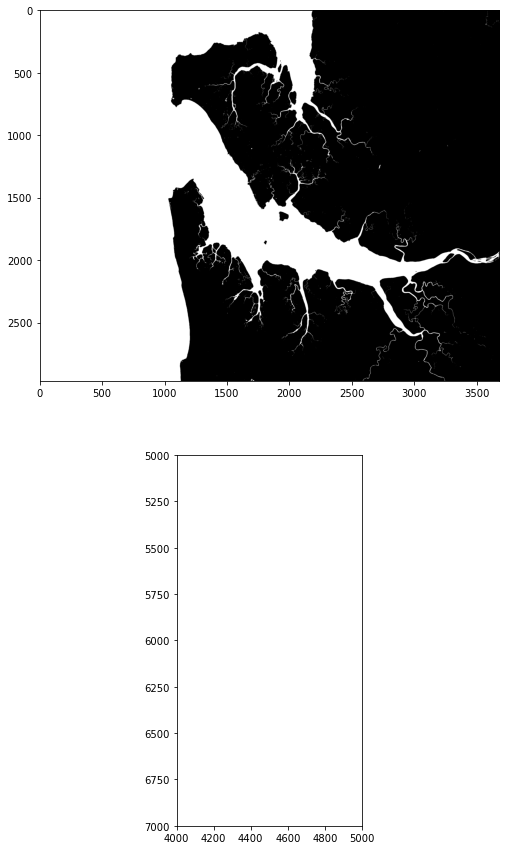

In [13]:
watermask = rasterio.open('%s%s_watermask_%s.tif' %(folders[8],AOI,res)).read(1)

fig,[ax1,ax2] = plt.subplots(nrows=2,figsize=(15,15))
ax1.imshow(watermask,'gray')

ax2.imshow(watermask,'gray')
ax2.axis([4000,5000, 7000,5000])

<font size='5' color = 'red' > STEP #3B: <br> Make polygons of each land cover type. This can be slow, depending on complexity of your watermask and size of study area </font>


<font size='3' color = 'red' > Water mask --> oceans, rivers, lakes, wetlands </font>


In [14]:
make_polygons(AOI,
                folders,
                parameters,
                ref,
                watermaskname,
                path_templates,
                os.path.isfile("%s%s_fulloceans_%s.shp" %(folders[7],AOI,res)))





##############################################################################################
################################[Step 4][Make_Polygons]######################################
##############################################################################################


[Step 4][Make_Polygons][Open land/water mask] .......

##################### Water delineated with gabon_ndvimin_ndwimin_clustered_finalwatermask_30

[Step 4][Make_Polygons] SKIP.......



lands
fullocean
lakes
rivers


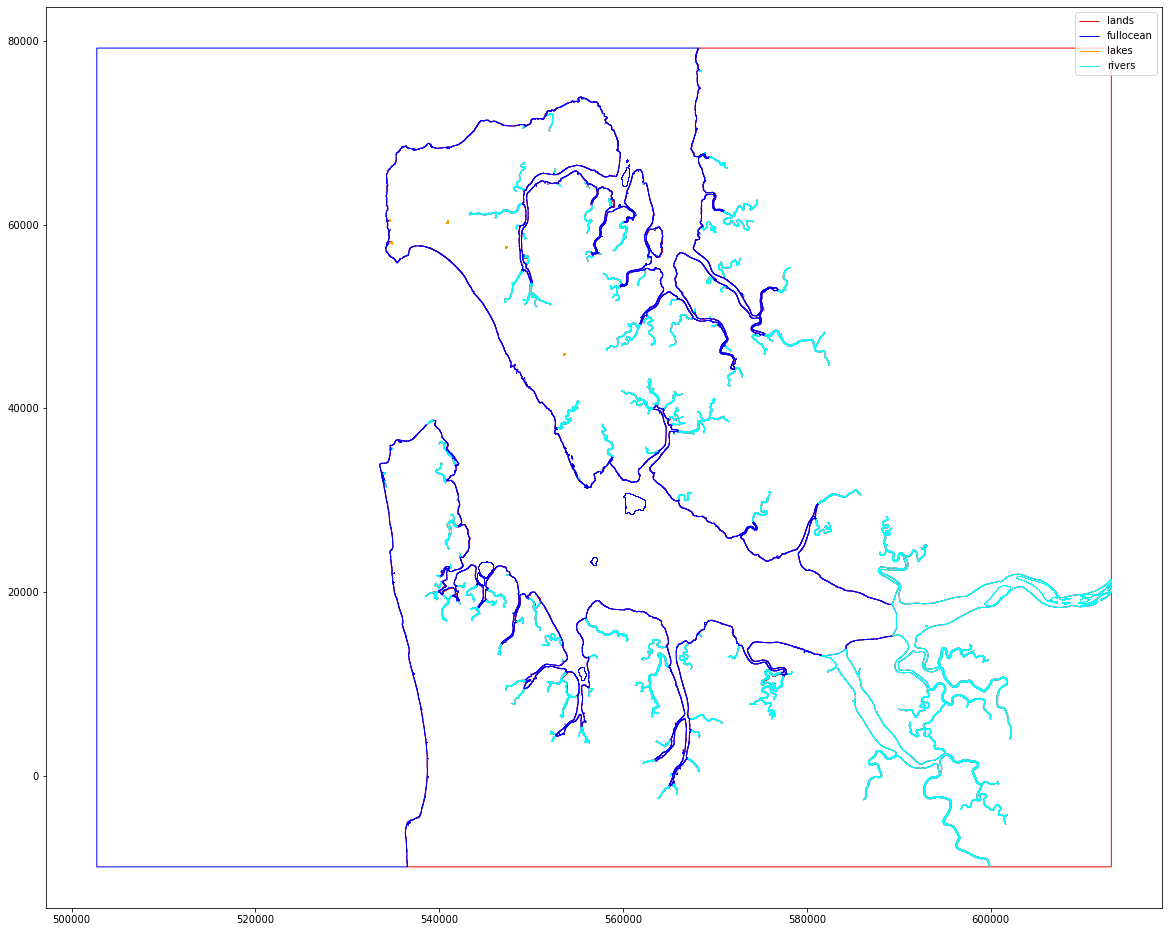

In [15]:
fix,ax = plt.subplots(figsize=(20,20))

colors = ['red','blue','orange','cyan','green']
polys = ['lands','fullocean','lakes','rivers']
i=0
for poly in polys:
    print(poly)
    tmp = gpd.read_file([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[7])
            for f in fnmatch.filter(files,'*%s*.shp' %(poly))][0])
    tmp.geometry.boundary.plot(color=colors[i], edgecolor=colors[i],linewidth = 1,ax=ax,label = poly) #Use your second dataframe
    #tmp.plot(ax=ax,color=,label=str(poly))
    i=i+1
plt.legend()


<font size='5' color = 'red' > STEP #4: <br> Using Orinoco, get distance and width files of the river networks</font>


<font size='3' color = 'red' > Width of network reaches is currently set to 150m, but this can be changed in the pixel_step variable </font>

In [16]:
segment_width = res*2
pixel_step = int(round(segment_width/res))
distance,widths = make_channel_networks(folders,
                                      AOI,
                                      ref,
                                      parameters,
                                      pixel_step,
                                      os.path.isfile("%s%s_widths_%sx%s.tif" %(folders[8],AOI,res,pixel_step)))






##############################################################################################
##############################[Step 5][Make_Channel_Networks]#################################
##############################################################################################


[Step 5][Make_Channel_Networks][Import river mask (30m)] .......


[Step 5][Make_Channel_Networks][Import ocean mask (30m)] .......


[Step 5][Make_Channel_Networks][Use Orinoco code (Charlie) to get distance and widths of rivers] .......

##################### Pixel step will be 2
##################### Therefore, segments will be 30 * 2 = 60m wide

[Step 5][Make_Channel_Networks] SKIP .......

0...10...20...30...40...50...60...70...80...90...100 - done.

[Step 5][Make_Channel_Networks][Finished] .......



<AxesSubplot:>

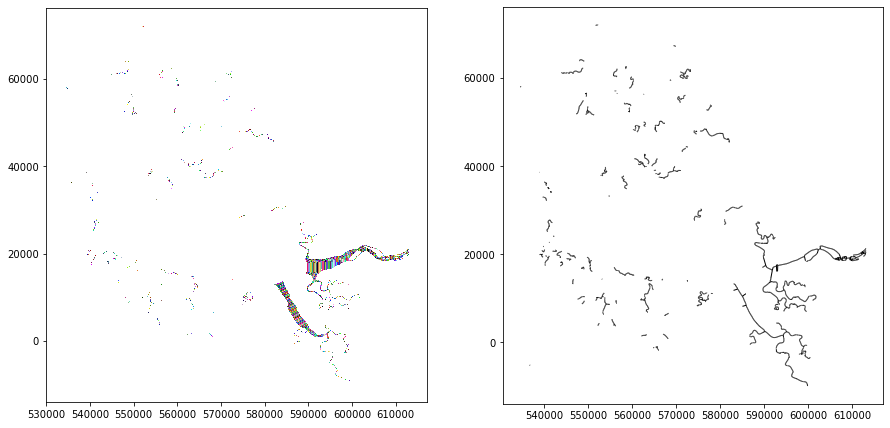

In [17]:
network_centerline = gpd.read_file('%s%s_river_centerline_%sx%s.shp' %(folders[7],AOI,res,pixel_step))
network_segments = gpd.read_file('%s%s_segments_%sx%s.shp' %(folders[7],AOI,res,pixel_step))
network_segments = network_segments[network_segments['DN']!=0]


fig,[ax1,ax2] = plt.subplots(ncols=2,figsize=(15,15))
network_segments.plot(ax = ax1, color=np.random.rand(len(network_segments),3))
network_centerline.plot(ax=ax2,color='black',linewidth=1)

<font size='5' color = 'red' > STEP #7: <br> Make the Digital Elevation Model </font>


In [18]:
elevation,elev_name,elevationpath = make_model_foundation(path,
                                                parameters,
                                                AOI,
                                                folders,
                                                ref,
                                                distance,
                                                widths,
                                                watermask,pixel_step,path
                                                )





##############################################################################################
###############################[Step 6][Make_Model_Foundation]################################
##############################################################################################


[Step 6][Make_Model_Foundation][Determine all methods for calculating elevation for each land/water type] .......

##################### Method for land = GLO30
##################### Method for ocean = GEBCO
##################### Method for lower river reaches = plane
##################### Method for upper river reaches = wdpower
##################### Method for lakes = constant_1
##################### Method for wetlands = constant_0
##################### Max Depth for Rivers = -300
##################### Max Depth for Oceans = -300
##################### Max Depth for Nearshore = -300
##################### Boundary between Upper and Lower river reaches =  12200m
/Volumes/FortressL3/ANUGA/SWOT_Sim/exam

/Users/alchrist/Documents/GitHub/ANUGA/processing/code/BYOM_Utilities_V1.py:1416: RuntimeWarning: invalid value encountered in divide
  parabola_depths = ((maxdepths/((widths/2)**2))*(proximity**2))-maxdepths


##################### River boundary: Distance = 12200m Depth = 11.027372360229492m 
##################### Ocean boundary: Distance = 1200m Depth = 1.1330472103004292m
##################### Lower river depth is determined with a linear relationship: Depth = 0.0008994841045390058 x Distance + 0.05366628485362224 based on linear relationship between width and depth using river mouth and upper river data points


/Users/alchrist/Documents/GitHub/ANUGA/processing/code/BYOM_Utilities_V1.py:1416: RuntimeWarning: divide by zero encountered in divide
  parabola_depths = ((maxdepths/((widths/2)**2))*(proximity**2))-maxdepths
/Users/alchrist/Documents/GitHub/ANUGA/processing/code/BYOM_Utilities_V1.py:1416: RuntimeWarning: invalid value encountered in multiply
  parabola_depths = ((maxdepths/((widths/2)**2))*(proximity**2))-maxdepths
/Users/alchrist/Documents/GitHub/ANUGA/processing/code/BYOM_Utilities_V1.py:1608: RuntimeWarning: invalid value encountered in divide
  river_elev=np.where(isriver==1,VV/WW,0)



[Step 6][Make_Model_Foundation][Building DEM][Building land topography] .....

##################### Land from /Volumes/FortressL3/ANUGA/SWOT_Sim/examples/gabon/Setup_Files/Setup_RST/gabon_topo.tif

[Step 6][Make_Model_Foundation][Building DEM][Building lake bathymetry] .....

##################### Lake Depth set with:  1.0m uniform

[Step 6][Make_Model_Foundation][Building DEM][Building wetland topography] .....

##################### Wetland elevation set with:  0.0m uniform

[Step 6][Make_Model_Foundation][Building DEM][Put it all together into final DEM] .....

##################### Elevation File: 
Elevation_ocean-GEBCO_land-GLO30_above12200m-wdpower_below12200m-plane_wetland-uni0m_lakes-uni1m
################################# Working directory will be: 
//Volumes/FortressL3/ANUGA/SWOT_Sim/examples/gabon/DEMs/Elevation_ocean-GEBCO_land-GLO30_above12200m-wdpower_below12200m-plane_wetland-uni0m_lakes-uni1m

[Step 6][Make_Model_Foundation][Make some figures] .......


[Step 6][Make_

<font size='5' color = 'red' > Get landcover map and associated Manning n roughness values</font>


In [19]:

landcovermethod = parameters['LandcoverMethod'][0]
landcover_file = rasterio.open([os.path.join(dirpath,f)
            for dirpath,dirnames, files in os.walk(folders[8])
            for f in fnmatch.filter(files,'*landcover_final.tif')][0])
save_profile = landcover_file.profile
landcover = landcover_file.read(1).astype('int')
print('\n##################### Fetching Manning coefficients LUT')
if landcovermethod == 'Copernicus':
    lut = np.genfromtxt(path_templates + 'Copernicus_manningLUT.csv',delimiter = ',')
elif landcovermethod == 'WorldCover':
    lut = np.genfromtxt(path_templates + 'WorldCover_manningLUT.csv',delimiter = ',')
else:
    lut = np.genfromtxt("%s%s_manningLUT.csv" %(folders[0],AOI),delimiter=',')
    
print('\n##################### Manning roughness coefficients set according to %s_ManningLUT.csv' %(landcovermethod))
manning = lut[landcover]
frict_name = 'Manning'
save_profile['dtype'] = 'float64'
with rasterio.open("%s%s_%s_%s.tif" %(folders[7],AOI,frict_name,landcovermethod),'w', **save_profile) as dst:
    dst.write_band(1,manning.astype('float64'))



##################### Fetching Manning coefficients LUT

##################### Manning roughness coefficients set according to WorldCover_ManningLUT.csv


In [20]:
print(elev_name)

Elevation_ocean-GEBCO_land-GLO30_above12200m-wdpower_below12200m-plane_wetland-uni0m_lakes-uni1m


In [21]:
cleanup = False 
if cleanup == True:
    print('Cleaning up temporary files')
    try:shutil.rmtree(folders[1])
    except:''


<font size=5 color='red'> Done building DEM and other ancillary files </font>
